In [1]:
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from IPython.display import display

In [2]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(torch.cuda.current_device()))

True
1
0
NVIDIA GeForce RTX 3060 Laptop GPU


In [107]:
df = pd.read_csv('results_1000_2.csv', header=None)
model_num = 0
# display(df)
results = df.to_numpy()
print(results.shape)
print(results[:,-1].shape)
X = torch.tensor(results[:,:-1]).to(torch.float32)
if model_num == 1:
    X = torch.reshape(X,(X.shape[0],1,10,10))
y = torch.tensor(np.expand_dims(results[:,-1], axis=1)).to(torch.float32)
print(X.shape, y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print(X_train.shape, y_train.shape)
# Setting up Dataloader
# training_dataset = TensorDataset(X_train, y_train)
# train_loader = DataLoader(training_dataset, batch_size=24, shuffle=True)

(1000, 101)
(1000,)
torch.Size([1000, 100]) torch.Size([1000, 1])
torch.Size([670, 100]) torch.Size([670, 1])


In [121]:
input_size = X.shape[1]
if model_num == 0:
    model = nn.Sequential(nn.Linear(input_size, 64),
                        nn.ReLU(),
                        nn.Linear(64,32),
                        nn.ReLU(),
                        nn.Linear(32,32),
                        nn.ReLU(),
                        nn.Linear(32, 1),
                        nn.Sigmoid())
else:
    model = nn.Sequential(nn.Conv2d(1,3,2),
                          nn.ReLU(),
                          nn.MaxPool2d(2,2),
                          nn.Conv2d(3,6,3),
                          nn.ReLU(),
                          nn.MaxPool2d(2,2),
                          nn.Flatten(),
                          nn.Linear(6, 30),
                          nn.ReLU(),
                          nn.Linear(30, 15),
                          nn.ReLU(),
                          nn.Linear(15,1),
                          nn.Sigmoid())
print(model)

Sequential(
  (0): Linear(in_features=100, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=32, bias=True)
  (5): ReLU()
  (6): Linear(in_features=32, out_features=1, bias=True)
  (7): Sigmoid()
)


In [122]:
loss_function = nn.MSELoss()
# loss_function = nn.BCELoss()

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.001)

In [123]:
losses = []
epochs = 150
for epoch in range(epochs):
  y_pred = model(X_train)
  loss = loss_function(y_pred, y_train)
  losses.append(loss.item())

  model.zero_grad()
  loss.backward()

  optimizer.step()

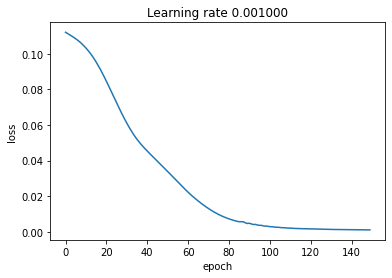

In [124]:
plt.plot(losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title("Learning rate %f"%(learning_rate))
plt.show()

In [125]:
y_pred = model(X_test)
loss = loss_function(y_pred, y_test)
print(loss.item())
compiled_results = y_test.detach().numpy()
compiled_results = np.append(compiled_results, y_pred.detach().numpy(), axis=1)
results = pd.DataFrame(compiled_results, columns = ['y_test','y_pred'])
pd.set_option('display.max_rows', 30)
display(results)
# print(y_pred.detach().numpy())

0.09864802658557892


,y_test,y_pred
0,0.808,0.768255
1,0.701,0.094674
2,0.398,0.896870
3,0.723,0.129311
4,0.910,0.661863
...,...,...
325,0.995,0.972078
326,0.916,0.691356
327,0.977,0.850139
328,0.184,0.296417


In [ ]:
def train_one_epoch(epoch_index):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(train_loader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_function(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 100 == 0:
            last_loss = running_loss / 100 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(train_loader) + i + 1
            running_loss = 0.

    return last_loss

EPOCHS = 50
losses = []

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch)
    losses.append(avg_loss)

    # We don't need gradients on to do reporting
    model.train(False)

EPOCH 0:


NameError: name 'train_loader' is not defined

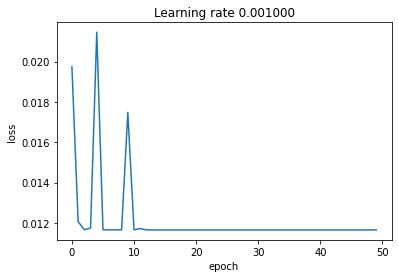

In [ ]:
plt.plot(losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title("Learning rate %f"%(learning_rate))
plt.show()

In [ ]:
y_pred = model(X_test)
loss = loss_function(y_pred, y_test)
print("Loss:", loss.item())
print("Accuracy: " + str(round(np.mean((y_test == y_pred.argmax(axis=1)).detach().numpy(), axis=0)*100, 3)) + "%")

Loss: 1.1981607675552368
Accuracy: 96.97%
